In [1]:
%load_ext autoreload
%autoreload 2

# Import Required Libraries
Import the necessary pdf2image and OpenAI.

In [2]:
# Importing required libraries
from fastcore.all import AttrDict
import io
from pdf2image import convert_from_path
from pypdf import PdfReader
import openai
import os
import base64
import requests
from dotenv import load_dotenv
import os

load_dotenv()  # Carga las variables de entorno desde .env

True

# Load and Convert PDF to Image
Use PyPDF2 pdf2image to load the PDF file and convert it into an image.

In [3]:
# Load the PDF file
path = '../example_data/1.pdf'

# Open and read the PDF file
reader = PdfReader(path)

# Check if the PDF has more than one page
if len(reader.pages) > 1:
    print("The PDF has more than one page. Only the first page will be converted to an image.")

# Convert the first page of the PDF to an image
images = convert_from_path(path, first_page=1, last_page=1, fmt='jpeg')


The PDF has more than one page. Only the first page will be converted to an image.


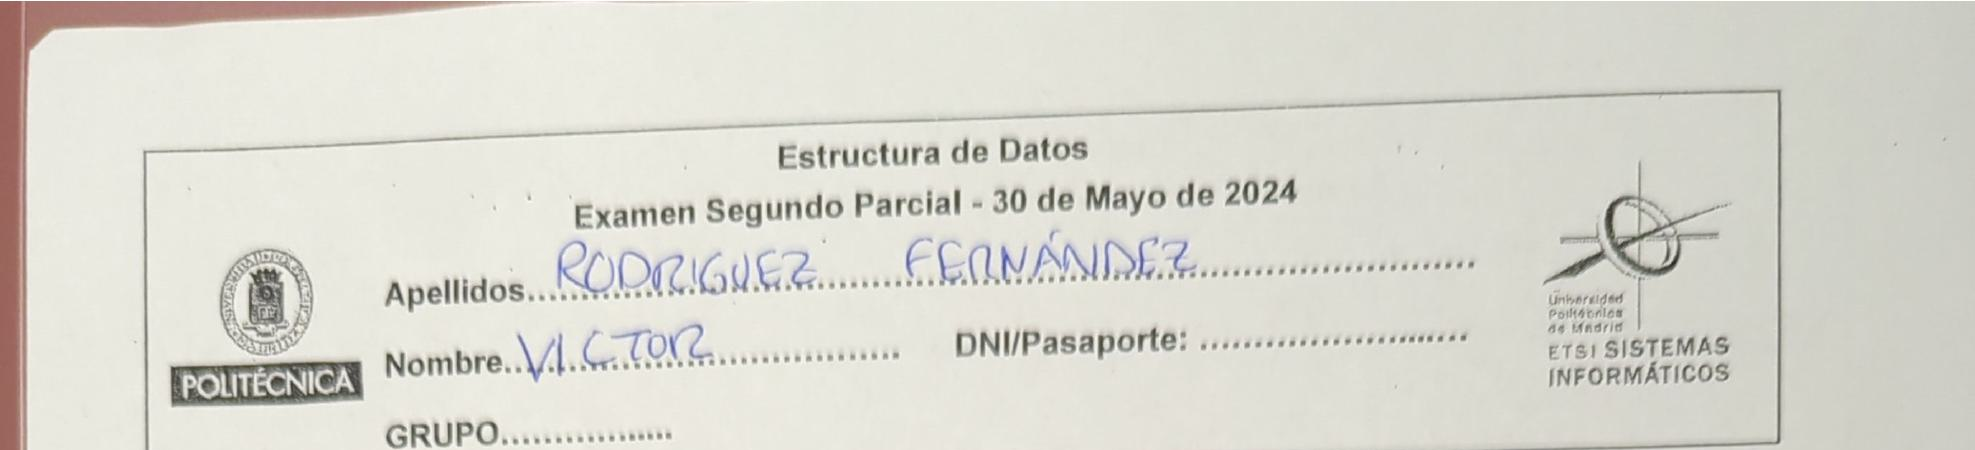

In [4]:
# Crop the image
image = images[0].crop((0, 0, images[0].width, 450))
image

# Call OpenAI ChatGPT API with Vision Model
Use the OpenAI API to call the ChatGPT model with the vision capability.

In [5]:
buffered = io.BytesIO()
images[0].save(buffered, format="JPEG")
base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
base64_image

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAraB7cDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCT/hINZ/6C19/4Ev8A40f8JBrGP+Qtf/8AgS/+NZtKOBXLdnrckexvaZrWrSXah9UvWXHQ3Dn+tOl1vVhcyqNTvQAxwPtD/wCNUNJz9sX6USktcTH/AGzRdicI32Lv9t6t/wBBS9/8CH/xpf7a1b/oKXv/AIEP/jWfSg0XYuS

In [6]:
# Load moodle students information
import pandas as pd

# Cargar el CSV de alumnos y grupos
students_info = ["./../data/courseid_422_participants.csv", "./../data/courseid_23101_participants.csv"]
dfs = [ pd.read_csv(filename) for filename in students_info ]

df = pd.concat(dfs, ignore_index=True)

# Puedes opcionalmente limpiar espacios y convertir a mayúsculas para facilitar coincidencias
df["Nombre"] = df["Nombre"].str.strip().str.upper()
df["Apellido(s)"] = df["Apellido(s)"].str.strip().str.upper()

guia_texto = "\n".join(
    f"{row['Nombre']} {row['Apellido(s)']} - Grupo: {row['Grupos']}"
    for _, row in df.iterrows()
)

In [7]:
#print(guia_texto[:3])
#print(guia_texto[3:])

In [8]:
api_key = os.environ["OPENAI_API_KEY"] # *
prompt = """Extract the last name (Apellidos in Spanish), the first name (Nombre in Spanish) and the group (Grupo in Spanish)
 from the top of the image. You will find them handwritten after the labels `Apellidos`,  `Nombre` and `Grupo` respectively. The fields of your JSON output will have those exact same label names
 Here is a list of expected students and their groups as a reference: 
 {guia_texto}
 """ # *
model = "gpt-4o"

In [9]:
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

payload = {
  "model": f'{model}',
  "response_format": { "type": "json_object" },
  "messages": [
    {
        "role": "system", 
        "content": "You are a helpful assistant designed to see an exam and output JSON \
           with the extracted information. You will be given an image of the exam.\
           the default group in case of empty string is extraviado",   
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": f"{prompt}"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
        }
      ]
    }
  ],
  "max_tokens": 300
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

In [10]:
import json

# Obtener el JSON como string
info_str = response.json()['choices'][0]['message']['content']

# Convertir a diccionario Python
info = json.loads(info_str)

# Si el grupo está vacío, marcarlo como "extraviado"
if not info.get("Grupo"):  # También cubre None y ""
    info["Grupo"] = "extraviado"

# Mostrar resultado
print(info)


{'Apellidos': 'RODRIGUEZ FERNANDEZ', 'Nombre': 'VICTOR', 'Grupo': 'extraviado'}


In [11]:
# Add path to the info dictionary
info['path'] = path

In [12]:
path

'../example_data/1.pdf'

In [13]:
import pandas as pd
import os
import zipfile
from pathlib import Path
import unicodedata
import re

def normalizar_texto(texto):
    """Normaliza texto eliminando acentos y caracteres especiales"""
    texto = unicodedata.normalize('NFD', texto)
    texto = ''.join(char for char in texto if unicodedata.category(char) != 'Mn')
    texto = texto.upper().strip()
    texto = re.sub(r'[^A-Z0-9\s]', '', texto)
    return texto

def buscar_practica_en_zips(apellidos, nombre, practica_num=3, ruta_data="./../data/"):
    """
    Busca si existe una práctica para un alumno en los archivos ZIP
    
    Args:
        apellidos: Apellidos del alumno
        nombre: Nombre del alumno
        practica_num: Número de práctica (3 o 5)
        ruta_data: Ruta base a la carpeta data
    """
    ruta_practica = Path(ruta_data) / f"Practica{practica_num}"
    
    if not ruta_practica.exists():
        return False
    
    # Normalizar apellidos y nombre
    apellidos_norm = normalizar_texto(apellidos)
    nombre_norm = normalizar_texto(nombre)
    
    # Buscar en todos los archivos ZIP
    for archivo_zip in ruta_practica.glob("*.zip"):
        try:
            with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
                for archivo in zip_ref.namelist():
                    archivo_norm = normalizar_texto(archivo)
                    
                    # Verificar si el archivo contiene apellidos y nombre
                    if apellidos_norm in archivo_norm and nombre_norm in archivo_norm:
                        return True
        except Exception as e:
            continue
    
    return False

def verificar_todas_las_practicas(df, ruta_data="./../data/"):
    """
    Añade columnas de verificación de prácticas al DataFrame existente
    
    Args:
        df: DataFrame con columnas 'Nombre' y 'Apellido(s)'
        ruta_data: Ruta base a la carpeta data
    
    Returns:
        DataFrame modificado con las nuevas columnas
    """
    
    # Crear copias para evitar warnings
    df_resultado = df.copy()
    
    # Inicializar las nuevas columnas
    df_resultado['Presentada_3'] = 0
    df_resultado['Comentario_3'] = 'NP'
    df_resultado['Presentada_5'] = 0
    df_resultado['Comentario_5'] = 'NP'
    
    print("Verificando entregas de prácticas...")
    print("="*50)
    
    practicas_3_encontradas = 0
    practicas_5_encontradas = 0
    total_alumnos = len(df_resultado)
    
    for idx, row in df_resultado.iterrows():
        nombre = str(row['Nombre'])
        apellidos = str(row['Apellido(s)'])
        
        # Verificar Práctica 3
        tiene_practica3 = buscar_practica_en_zips(apellidos, nombre, 3, ruta_data)
        if tiene_practica3:
            df_resultado.loc[idx, 'Presentada_3'] = 1
            df_resultado.loc[idx, 'Comentario_3'] = ''
            practicas_3_encontradas += 1
        
        # Verificar Práctica 5
        tiene_practica5 = buscar_practica_en_zips(apellidos, nombre, 5, ruta_data)
        if tiene_practica5:
            df_resultado.loc[idx, 'Presentada_5'] = 1
            df_resultado.loc[idx, 'Comentario_5'] = ''
            practicas_5_encontradas += 1
        
        # Mostrar progreso
        status_3 = "✓" if tiene_practica3 else "✗"
        status_5 = "✓" if tiene_practica5 else "✗"
        print(f"{status_3} P3 | {status_5} P5 | {apellidos}, {nombre}")
    
    print("="*50)
    print(f"RESUMEN:")
    print(f"Total alumnos verificados: {total_alumnos}")
    print(f"Práctica 3 - Entregadas: {practicas_3_encontradas} | No entregadas: {total_alumnos - practicas_3_encontradas}")
    print(f"Práctica 5 - Entregadas: {practicas_5_encontradas} | No entregadas: {total_alumnos - practicas_5_encontradas}")
    
    return df_resultado

In [14]:
# Load moodle students information
import pandas as pd
# Cargar el CSV de alumnos y grupos
students_info = ["./../data/courseid_422_participants.csv", "./../data/courseid_23101_participants.csv"]
dfs = [ pd.read_csv(filename) for filename in students_info ]
df = pd.concat(dfs, ignore_index=True)
# Limpiar espacios y convertir a mayúsculas
df["Nombre"] = df["Nombre"].str.strip().str.upper()
df["Apellido(s)"] = df["Apellido(s)"].str.strip().str.upper()
print("DataFrame original cargado:")
print(f"Total alumnos: {len(df)}")
print(df.head())
print("\n")

# Verificar prácticas y añadir columnas
df_con_practicas = verificar_todas_las_practicas(df)

print("\nDataFrame con verificación de prácticas:")
print(df_con_practicas.head())

# Mostrar estadísticas por grupo si existe la columna
if 'Grupos' in df_con_practicas.columns:
    print("\nEstadísticas por grupo:")
    resumen_grupos = df_con_practicas.groupby('Grupos').agg({
        'Presentada_3': 'sum',
        'Presentada_5': 'sum'
    })
    print(resumen_grupos)

DataFrame original cargado:
Total alumnos: 444
        Nombre       Apellido(s)                   Dirección de correo  \
0        SOFIA   AGAPITO DELGADO              s.agapito@alumnos.upm.es   
1  LLOYD DAREN    AGUILAR DESIAR          daren.aguilar@alumnos.upm.es   
2       JAVIER   AGUIRRE HERVIAS  javier.aguirrehervias@alumnos.upm.es   
3        MATEO          ALBRIZIO         mateo.albrizio@alumnos.upm.es   
4      NICOLAS  ALONSO FERNANDEZ              ni.alonso@alumnos.upm.es   

    Grupos  
0  IWSIT11  
1  IWSIM12  
2  IWSIM12  
3  IWSIM12  
4  IWSIM12  


Verificando entregas de prácticas...
✗ P3 | ✓ P5 | AGAPITO DELGADO, SOFIA
✗ P3 | ✓ P5 | AGUILAR DESIAR, LLOYD DAREN
✗ P3 | ✓ P5 | AGUIRRE HERVIAS, JAVIER
✗ P3 | ✓ P5 | ALBRIZIO, MATEO
✗ P3 | ✗ P5 | ALONSO FERNANDEZ, NICOLAS
✗ P3 | ✓ P5 | ALVAREZ AREVALO, MIGUEL
✗ P3 | ✓ P5 | APUNTE SIERRA, AARON ALEJANDRO
✗ P3 | ✗ P5 | ARTACHO BORDINO, JORGE
✗ P3 | ✓ P5 | AUSIN MORENO, MARCOS
✗ P3 | ✓ P5 | AYALA MAYA, JULIO
✗ P3 | ✓ P5 | AYD

In [15]:
display(df_con_practicas)

,Nombre,Apellido(s),Dirección de correo,Grupos,Presentada_3,Comentario_3,Presentada_5,Comentario_5
0,SOFIA,AGAPITO DELGADO,s.agapito@alumnos.upm.es,IWSIT11,0,NP,1,
1,LLOYD DAREN,AGUILAR DESIAR,daren.aguilar@alumnos.upm.es,IWSIM12,0,NP,1,
2,JAVIER,AGUIRRE HERVIAS,javier.aguirrehervias@alumnos.upm.es,IWSIM12,0,NP,1,
3,MATEO,ALBRIZIO,mateo.albrizio@alumnos.upm.es,IWSIM12,0,NP,1,
4,NICOLAS,ALONSO FERNANDEZ,ni.alonso@alumnos.upm.es,IWSIM12,0,NP,0,NP
...,...,...,...,...,...,...,...,...
439,HAOQING,ZHANG,haoqing.zhang@alumnos.upm.es,CITIT11,0,NP,0,NP
440,JIONGHAO,ZHANG,jionghao.zhang@alumnos.upm.es,CITIM12,1,,1,
441,STEVEN WEI,ZHANG XIA,steven.zhang@alumnos.upm.es,CITIT11,0,NP,1,
442,YI,ZHOU,yi.zhou@alumnos.upm.es,CITIT11,0,NP,1,


In [16]:
df_con_practicas.to_csv("../data/practicas_3_5")

In [17]:
# Seleccionar un grupo en concreto
columnas_importantes = ['Nombre', 'Apellido(s)', 'Presentada_5', 'Comentario_5']
df_con_practicas[df_con_practicas['Grupos'] == 'CITIT11'][columnas_importantes].to_csv('../data/alumnos_CITIT11.csv', index=False)

In [18]:
def renombrar_archivos_en_lotes(ruta="../data/raw/"):
	"""
	Renombra todos los archivos en la carpeta dada como 'lote_1', 'lote_2', etc.
	Conserva la extensión original de cada archivo.
	"""
	archivos = sorted([f for f in os.listdir(ruta) if os.path.isfile(os.path.join(ruta, f))])
	for idx, nombre_original in enumerate(archivos, start=1):
		extension = os.path.splitext(nombre_original)[1]
		nuevo_nombre = f"lote_{idx}{extension}"
		ruta_origen = os.path.join(ruta, nombre_original)
		ruta_destino = os.path.join(ruta, nuevo_nombre)
		os.rename(ruta_origen, ruta_destino)
	print(f"Renombrados {len(archivos)} archivos en '{ruta}'.")
#renombrar_archivos_en_lotes()

In [19]:
import os
from pathlib import Path
from pypdf import PdfReader, PdfWriter

def crear_carpeta_examenes(base_dir="../data", nombre_base="examenes"):
    """
    Crea una carpeta nueva para los exámenes. Si ya existe, añade un sufijo numérico.
    """
    base_path = Path(base_dir)
    carpeta = base_path / nombre_base
    contador = 1
    while carpeta.exists():
        carpeta = base_path / f"{nombre_base}_{contador}"
        contador += 1
    carpeta.mkdir(parents=True)
    return carpeta

def dividir_pdf_en_examenes(pdf_path, carpeta_destino, nombre_base="examen"):
    """
    Divide un PDF en archivos de 2 páginas cada uno y los guarda en la carpeta destino.
    """
    reader = PdfReader(pdf_path)
    num_paginas = len(reader.pages)
    examen_idx = 1
    for i in range(0, num_paginas, 2):
        writer = PdfWriter()
        writer.add_page(reader.pages[i])
        if i+1 < num_paginas:
            writer.add_page(reader.pages[i+1])
        nombre_examen = f"{nombre_base}_{examen_idx}.pdf"
        ruta_examen = carpeta_destino / nombre_examen
        with open(ruta_examen, "wb") as f_out:
            writer.write(f_out)
        examen_idx += 1

def procesar_lotes_y_generar_examenes(ruta_lotes="../data/raw/", base_dir="../data", nombre_carpeta="examenes"):
    """
    Busca todos los archivos PDF en la carpeta de lotes, los divide de 2 en 2 páginas y los guarda en una carpeta nueva.
    """
    carpeta_destino = crear_carpeta_examenes(base_dir, nombre_carpeta)
    archivos_lote = sorted([f for f in os.listdir(ruta_lotes) if f.lower().endswith(".pdf")])
    examen_global_idx = 1
    for archivo in archivos_lote:
        ruta_pdf = Path(ruta_lotes) / archivo
        reader = PdfReader(ruta_pdf)
        num_paginas = len(reader.pages)
        for i in range(0, num_paginas, 2):
            writer = PdfWriter()
            writer.add_page(reader.pages[i])
            if i+1 < num_paginas:
                writer.add_page(reader.pages[i+1])
            nombre_examen = f"examen_{examen_global_idx}.pdf"
            ruta_examen = carpeta_destino / nombre_examen
            with open(ruta_examen, "wb") as f_out:
                writer.write(f_out)
            examen_global_idx += 1
    print(f"Exámenes generados en: {carpeta_destino}")

# Ejemplo de uso:
procesar_lotes_y_generar_examenes()

Exámenes generados en: ..\data\examenes_3


In [20]:
import os
from pathlib import Path
from pdf2image import convert_from_path
from pypdf import PdfReader, PdfWriter
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Output, Layout, Label, Dropdown
from IPython.display import display, clear_output

class JupyterPDFReviewer:
    def __init__(self, pdf_path):
        self.pdf_path = pdf_path
        self.reader = PdfReader(pdf_path)
        self.total_pages = len(self.reader.pages)
        self.current_index = 0
        self.images = {}
        self.output_dir = Path("../data/saved")
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.out = Output()
        self.status = Label(value="")  # Estado visual
        self._setup_widgets()
        self._show_pages()

    def _setup_widgets(self):
        self.btn_save1 = Button(description='Save Page 1', layout=Layout(width='120px'))
        self.btn_save12 = Button(description='Save Pages 1&2', layout=Layout(width='120px'))
        self.btn_save123 = Button(description='Save Pages 1-3', layout=Layout(width='120px'))
        self.btn_next = Button(description='Next (Skip 1)', layout=Layout(width='120px'))
        self.btn_prev = Button(description='Previous', layout=Layout(width='120px'))

        self.btn_save1.on_click(lambda x: self._save_pages([0]))
        self.btn_save12.on_click(lambda x: self._save_pages([0, 1]))
        self.btn_save123.on_click(lambda x: self._save_pages([0, 1, 2]))
        self.btn_next.on_click(lambda x: self._next_page())
        self.btn_prev.on_click(lambda x: self._prev_page())

        display(VBox([
            HBox([self.btn_prev, self.btn_save1, self.btn_save12, self.btn_save123, self.btn_next]),
            self.status,
            self.out
        ]))

    def _get_page_image(self, idx):
        if idx not in self.images and idx < self.total_pages:
            self.status.value = f"Cargando página {idx+1}..."
            try:
                img = convert_from_path(
                    self.pdf_path,
                    first_page=idx + 1,
                    last_page=idx + 1,
                    dpi=50,
                    fmt='jpeg',
                    thread_count=1
                )[0]
                self.images[idx] = img
            except Exception as e:
                self.status.value = f"Error cargando página {idx+1}"
                print(f"Error converting page {idx+1}: {e}")
                return None
        self.status.value = ""
        return self.images.get(idx)

    def _show_pages(self):
        with self.out:
            clear_output(wait=True)
            fig, axes = plt.subplots(1, 3, figsize=(15, 8))
            for i in range(3):
                page_idx = self.current_index + i
                axes[i].axis('off')
                if page_idx < self.total_pages:
                    img = self._get_page_image(page_idx)
                    if img is not None:
                        axes[i].imshow(img)
                        axes[i].set_title(f"Page {page_idx+1}")
                    else:
                        axes[i].set_title(f"Page {page_idx+1} (error)")
                else:
                    axes[i].set_title("No Page")
            plt.show()

    def _next_page(self):
        if self.current_index + 1 < self.total_pages:
            self.current_index += 1
            self._show_pages()

    def _prev_page(self):
        if self.current_index >= 1:
            self.current_index -= 1
            self._show_pages()

    def _save_pages(self, rel_indices):
        abs_indices = [self.current_index + i for i in rel_indices if self.current_index + i < self.total_pages]
        if not abs_indices:
            self.status.value = "No valid pages to save"
            return

        base_name = Path(self.pdf_path).stem  # Ejemplo: 'lote_1'
        lote = base_name
        examen_n = abs_indices[0] + 1  # Primer índice de página + 1
        output_path = self.output_dir / f"{lote}_examen_{examen_n}.pdf"

        writer = PdfWriter()
        for idx in abs_indices:
            writer.add_page(self.reader.pages[idx])
        with open(output_path, "wb") as f:
            writer.write(f)
        self.status.value = f"Guardado: {output_path.name}"

        # Avanzar tantas páginas como se han guardado
        avance = len(abs_indices)
        if self.current_index + avance < self.total_pages:
            self.current_index += avance
            self._show_pages()

def revisar_todos_los_lotes(ruta_lotes="../data/raw/"):
    archivos = sorted([f for f in os.listdir(ruta_lotes) if f.lower().endswith(".pdf")])
    if not archivos:
        print("No se encontraron lotes PDF en la carpeta.")
        return
    dropdown = Dropdown(options=archivos, description='Lote:', layout=Layout(width='50%'))
    out = Output()

    def on_select(change):
        with out:
            clear_output(wait=True)
            print(f"Revisando: {dropdown.value}")
            JupyterPDFReviewer(os.path.join(ruta_lotes, dropdown.value))

    dropdown.observe(on_select, names='value')
    display(VBox([dropdown, out]))
    # Mostrar el primero por defecto
    on_select({'new': archivos[0]})

# Ejemplo de uso:
# revisar_todos_los_lotes("../data/raw/")

In [21]:
#revisar_todos_los_lotes("../data/raw/") # --> solo cuando necesites procesar los lotes

In [22]:
import os
import json
import base64
from pathlib import Path
from pdf2image import convert_from_path
from pypdf import PdfReader
import pandas as pd
import shutil
import io
import requests

def procesar_examenes_completo(carpeta_examenes="../data/saved/", output_dir="../data/examenes_procesados/"):
    """
    Procesa todos los exámenes de la carpeta, extrae información con OpenAI,
    los organiza por grupo y práctica, y genera un DataFrame de seguimiento.
    """
    # Crear directorio de salida
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Lista para almacenar información de exámenes procesados
    examenes_info = []
    
    # Obtener todos los archivos PDF
    pdf_files = list(Path(carpeta_examenes).glob("*.pdf"))
    
    print(f"Procesando {len(pdf_files)} exámenes...")
    
    # Variables necesarias para la API
    api_key = os.environ["OPENAI_API_KEY"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    for pdf_file in pdf_files:
        print(f"\nProcesando: {pdf_file.name}")
        
        try:
            # Procesar cada página del PDF
            reader = PdfReader(pdf_file)
            num_pages = len(reader.pages)
            
            for page_num in range(min(2, num_pages)):  # Solo primeras 2 páginas
                # Convertir página a imagen
                images = convert_from_path(
                    pdf_file, 
                    first_page=page_num + 1, 
                    last_page=page_num + 1, 
                    dpi=150,
                    fmt='jpeg'
                )
                
                if not images:
                    continue
                    
                # Convertir imagen a base64
                buffered = io.BytesIO()
                images[0].save(buffered, format="JPEG")
                base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
                
                # Llamar a OpenAI
                info = extraer_info_con_openai(base64_image, headers)
                
                if info and info.get('Apellidos') and info.get('Nombre'):
                    info['archivo_original'] = pdf_file.name
                    info['pagina'] = page_num + 1
                    
                    # Organizar archivo por grupo y práctica
                    mover_archivo_organizado(pdf_file, info, output_path)
                    
                    examenes_info.append(info)
                    practica = info.get('practica_detectada', 'desconocida')
                    print(f"✓ Extraído: {info['Nombre']} {info['Apellidos']} - Grupo: {info['Grupo']} - Práctica: {practica}")
                    break  # Si encontramos info en una página, no procesar más páginas
                    
        except Exception as e:
            print(f"✗ Error procesando {pdf_file.name}: {e}")
            continue
    
    # Crear DataFrame de seguimiento
    df_examenes = crear_dataframe_examenes(examenes_info)
    
    # Guardar DataFrame
    df_examenes.to_csv(output_path / "seguimiento_examenes.csv", index=False)
    
    print(f"\n📊 Procesamiento completado:")
    print(f"- Exámenes procesados: {len(examenes_info)}")
    print(f"- Archivo de seguimiento guardado en: {output_path / 'seguimiento_examenes.csv'}")
    
    return df_examenes

def extraer_info_con_openai(base64_image, headers):
    """Extrae información del examen usando OpenAI"""
    try:
        prompt_completo = f"""Extract the last name (Apellidos in Spanish), the first name (Nombre in Spanish) and the group (Grupo in Spanish)
         from the top of the image. You will find them handwritten after the labels `Apellidos`,  `Nombre` and `Grupo` respectively. 
         The fields of your JSON output will have those exact same label names.
         Also determine if this is a "Práctica de Listas" (practice 3) or "Práctica de Grafos" (practice 5) based on the content.
         Add a field called "practica_detectada" with value 3 for listas or 5 for grafos.
         Here is a list of expected students and their groups as a reference: 
         {guia_texto}
         """
        
        payload = {
            "model": "gpt-4o",
            "response_format": {"type": "json_object"},
            "messages": [
                {
                    "role": "system", 
                    "content": "You are a helpful assistant designed to see an exam and output JSON with the extracted information. The default group in case of empty string is extraviado",   
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt_completo
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": 300
        }
        
        response = requests.post(
            "https://api.openai.com/v1/chat/completions", 
            headers=headers, 
            json=payload
        )
        
        if response.status_code == 200:
            info_str = response.json()['choices'][0]['message']['content']
            info = json.loads(info_str)
            
            # Si el grupo está vacío, marcarlo como "extraviado"
            if not info.get("Grupo"):
                info["Grupo"] = "extraviado"
                
            return info
        else:
            print(f"Error en API OpenAI: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Error extrayendo información: {e}")
        return None

def mover_archivo_organizado(archivo_original, info, output_path):
    """Organiza el archivo en carpetas por GRUPO y luego por PRÁCTICA"""
    try:
        practica = info.get('practica_detectada', 'desconocida')
        grupo = info.get('Grupo', 'extraviado')
        
        # Crear estructura de carpetas: GRUPO -> PRÁCTICA
        carpeta_grupo = output_path / grupo
        carpeta_practica = carpeta_grupo / f"Practica_{practica}"
        carpeta_practica.mkdir(parents=True, exist_ok=True)
        
        # Generar nombre de archivo
        apellidos = info.get('Apellidos', 'SinApellidos').replace(' ', '_')
        nombre = info.get('Nombre', 'SinNombre').replace(' ', '_')
        
        nombre_base = f"{apellidos}_{nombre}"
        extension = archivo_original.suffix
        nuevo_archivo = carpeta_practica / f"{nombre_base}{extension}"
        
        # Si ya existe, añadir sufijo numérico
        contador = 2
        while nuevo_archivo.exists():
            nuevo_archivo = carpeta_practica / f"{nombre_base}_{contador}{extension}"
            contador += 1
        
        # Copiar archivo
        shutil.copy2(archivo_original, nuevo_archivo)
        print(f"  → Guardado en: {carpeta_grupo.name}/{carpeta_practica.name}/{nuevo_archivo.name}")
        
    except Exception as e:
        print(f"Error organizando archivo {archivo_original.name}: {e}")

def crear_dataframe_examenes(examenes_info):
    """Crea DataFrame de seguimiento de exámenes"""
    # Crear DataFrame base con todos los estudiantes
    df_base = df[['Nombre', 'Apellido(s)', 'Grupos']].copy()
    
    # Inicializar columnas de exámenes
    df_base['Examen_3'] = 0
    df_base['Comentario_Examen_3'] = 'PNP'  # PNP = No Presentado
    df_base['Examen_5'] = 0
    df_base['Comentario_Examen_5'] = 'PNP'  # PNP = No Presentado
    
    # Procesar información de exámenes
    for examen in examenes_info:
        practica = examen.get('practica_detectada')
        if practica in [3, 5, '3', '5']:
            practica = str(practica)
            
            # Buscar estudiante en el DataFrame
            apellidos = examen.get('Apellidos', '').upper().strip()
            nombre = examen.get('Nombre', '').upper().strip()
            
            # Buscar coincidencia (más flexible)
            mask = df_base['Apellido(s)'].str.upper().str.contains(apellidos[:5] if len(apellidos) > 5 else apellidos, na=False, regex=False) & \
                   df_base['Nombre'].str.upper().str.contains(nombre[:5] if len(nombre) > 5 else nombre, na=False, regex=False)
            
            if mask.any():
                df_base.loc[mask, f'Examen_{practica}'] = 1
                df_base.loc[mask, f'Comentario_Examen_{practica}'] = ''  # Limpiar PNP
                print(f"  → Marcado como presentado: {nombre} {apellidos} - Práctica {practica}")
    
    return df_base



In [ ]:
import os
import json
import base64
from pathlib import Path
from pdf2image import convert_from_path
from pypdf import PdfReader
import pandas as pd
import shutil
import io
import requests
import time
from rapidfuzz import fuzz
import re

def buscar_grupo_flexible(nombre, apellidos, df, texto_ocr=None, umbral=90):
    """
    Busca el grupo del alumno en el DataFrame por nombre y apellidos usando fuzzy.
    Si no encuentra, intenta detectar el grupo en el texto OCR.
    """
    nombre = nombre.strip().upper()
    apellidos = apellidos.strip().upper()
    mejor_score = 0
    mejor_grupo = None
    for _, row in df.iterrows():
        score_nombre = fuzz.ratio(nombre, str(row["Nombre"]).strip().upper())
        score_apellidos = fuzz.ratio(apellidos, str(row["Apellido(s)"]).strip().upper())
        score = (score_nombre + score_apellidos) / 2
        if score > mejor_score and score >= umbral:
            mejor_score = score
            mejor_grupo = row["Grupos"]

    if mejor_grupo:
        return mejor_grupo

    # Si no encuentra por nombre, intenta detectar grupo en el texto OCR
    if texto_ocr:
        texto_ocr = texto_ocr.upper()
        patrones = [
            r"CITI[TM][1][12]", r"IWSI[TM][1][12]", r"IWSIT[1][12]", r"CITIT[1][12]", r"IWSIM[1][12]"
        ]
        for patron in patrones:
            match = re.search(patron, texto_ocr)
            if match:
                return match.group(0)
    return "extraviado"

def extraer_info_con_openai(base64_image, headers, df):
    """Extrae información del examen usando OpenAI con timeout y control de errores, y asigna grupo usando fuzzy y OCR"""
    try:
        prompt_completo = (
            "Extract the last name (Apellidos in Spanish), "
            "the first name (Nombre in Spanish) from the top of the image. "
            "Extract also the group (Grupo in Spanish) from the top of the image. "
            "You will find them handwritten after the labels `Apellidos` and `Nombre` and `Group` respectively. "
            "The fields of your JSON output will have those exact same label names. "
            "Also determine if this is a \"Práctica de Listas\" (practice 3) or \"Práctica de Grafos\" (practice 5) based on the content. "
            "Add a field called \"practica_detectada\" with value 3 for listas or 5 for grafos. "
            "If you see a group label like CITIM11, CITIM12, IWSIM11, IWSIM12, CITIT11, IWSIT11, IWSIT12, include it as the field 'Grupo'."
        )
            
        payload = {
            "model": "gpt-4o",
            "response_format": {"type": "json_object"},
            "messages": [
                {
                    "role": "system",
                    "content": "You are a helpful assistant designed to see an exam and output JSON with the extracted information."
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_completo},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }
            ],
            "max_tokens": 300
        }
        try:
            response = requests.post(
                "https://api.openai.com/v1/chat/completions",
                headers=headers,
                json=payload,
                timeout=10
            )
        except requests.exceptions.Timeout:
            print("❗ Timeout: La petición a OpenAI tardó más de 10 segundos.")
            return None
        except requests.exceptions.RequestException as e:
            print(f"❗ Error de conexión con OpenAI: {e}")
            return None

        if response.status_code == 200:
            info_str = response.json()['choices'][0]['message']['content']
            try:
                info = json.loads(info_str)
                nombre = info.get("Nombre", "").strip().upper()
                apellidos = info.get("Apellidos", "").strip().upper()
                grupo_ocr = info.get("Grupo", "")
                grupo = buscar_grupo_flexible(nombre, apellidos, df, texto_ocr=grupo_ocr)
                info["Grupo"] = grupo
                # Guarda el grupo detectado por OCR si no es extraviado
                if grupo == "extraviado" and grupo_ocr:
                    info["Grupo_detectado"] = grupo_ocr
                return info
            except json.JSONDecodeError as e:
                print(f"Error parseando JSON: {e}")
                print(f"Respuesta recibida: {info_str}")
                return None
        else:
            print(f"Error en API OpenAI: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error extrayendo información: {e}")
        return None

def extraer_solo_practica(base64_image, headers):
    """Intenta extraer solo la práctica cuando falla la extracción completa"""
    try:
        prompt_practica = """Look at this exam image and determine if this is a "Práctica de Listas" (practice 3) or "Práctica de Grafos" (practice 5) based on the content. Return JSON with fields: "Apellidos": "", "Nombre": "", "Grupo": "extraviado", "practica_detectada": 3 or 5"""
        payload = {
            "model": "gpt-4o",
            "response_format": {"type": "json_object"},
            "messages": [
                {
                    "role": "system",
                    "content": "You are a helpful assistant that identifies exam types and outputs JSON.",
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt_practica},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ]
                }
            ],
            "max_tokens": 150
        }
        try:
            response = requests.post(
                "https://api.openai.com/v1/chat/completions",
                headers=headers,
                json=payload,
                timeout=10
            )
        except requests.exceptions.Timeout:
            print("❗ Timeout: La petición a OpenAI tardó más de 10 segundos (solo práctica).")
            return None
        except requests.exceptions.RequestException as e:
            print(f"❗ Error de conexión con OpenAI (solo práctica): {e}")
            return None

        if response.status_code == 200:
            info_str = response.json()['choices'][0]['message']['content']
            try:
                info = json.loads(info_str)
                return info
            except json.JSONDecodeError:
                return None
        else:
            print(f"Error en API OpenAI (solo práctica): {response.status_code}")
            return None
    except Exception as e:
        print(f"Error en retry de práctica: {e}")
        return None

def mover_archivo_organizado(archivo_original, info, output_path):
    """Organiza el archivo en carpetas por GRUPO y luego por PRÁCTICA"""
    try:
        practica = info.get('practica_detectada', 'desconocida')
        grupo = info.get('Grupo', 'extraviado')
        carpeta_grupo = output_path / grupo
        carpeta_practica = carpeta_grupo / f"Practica_{practica}"
        carpeta_practica.mkdir(parents=True, exist_ok=True)
        apellidos = info.get('Apellidos', 'SinApellidos').replace(' ', '_')
        nombre = info.get('Nombre', 'SinNombre').replace(' ', '_')
        nombre_base = f"{apellidos}_{nombre}"
        # Si es extraviado pero hay grupo detectado, añádelo al nombre
        if grupo == "extraviado" and info.get('Grupo_detectado'):
            nombre_base += f"_{info['Grupo_detectado']}"
        extension = archivo_original.suffix
        nuevo_archivo = carpeta_practica / f"{nombre_base}{extension}"
        contador = 2
        while nuevo_archivo.exists():
            nuevo_archivo = carpeta_practica / f"{nombre_base}_{contador}{extension}"
            contador += 1
        shutil.copy2(archivo_original, nuevo_archivo)
        print(f"  → Guardado en: {carpeta_grupo.name}/{carpeta_practica.name}/{nuevo_archivo.name}")
    except Exception as e:
        print(f"Error organizando archivo {archivo_original.name}: {e}")

def crear_dataframe_examenes(examenes_info, df):
    """Crea DataFrame de seguimiento de exámenes"""
    df_base = df[['Nombre', 'Apellido(s)', 'Grupos']].copy()
    df_base['Examen_3'] = 0
    df_base['Comentario_Examen_3'] = 'PNP'
    df_base['Examen_5'] = 0
    df_base['Comentario_Examen_5'] = 'PNP'
    for examen in examenes_info:
        practica = examen.get('practica_detectada')
        if practica in [3, 5, '3', '5']:
            practica = str(practica)
            apellidos = examen.get('Apellidos', '').upper().strip()
            nombre = examen.get('Nombre', '').upper().strip()
            if apellidos and nombre:
                mask = df_base['Apellido(s)'].str.upper().str.strip() == apellidos
                mask &= df_base['Nombre'].str.upper().str.strip() == nombre
                if mask.any():
                    df_base.loc[mask, f'Examen_{practica}'] = 1
                    df_base.loc[mask, f'Comentario_Examen_{practica}'] = ''
                    print(f"  → Marcado como presentado: {nombre} {apellidos} - Práctica {practica}")
    return df_base

def procesar_examenes_completo(carpeta_examenes="../data/saved/", output_dir="../data/examenes_procesados/"):
    """
    Procesa todos los exámenes de la carpeta, extrae información con OpenAI,
    los organiza por grupo y práctica, y genera un DataFrame de seguimiento.
    """
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    extraviados_path = output_path / "extraviados"
    extraviados_path.mkdir(parents=True, exist_ok=True)
    examenes_info = []
    pdf_files = sorted(Path(carpeta_examenes).glob("*.pdf"), key=lambda x: x.name)
    print(f"Procesando {len(pdf_files)} exámenes...")
    api_key = os.environ["OPENAI_API_KEY"]
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    for pdf_file in pdf_files:
        print(f"\nProcesando: {pdf_file.name}")
        try:
            reader = PdfReader(pdf_file)
            num_pages = len(reader.pages)
            info_extraida = None
            for page_num in range(min(2, num_pages)):
                images = convert_from_path(
                    pdf_file,
                    first_page=page_num + 1,
                    last_page=page_num + 1,
                    dpi=150,
                    fmt='jpeg'
                )
                if not images:
                    continue
                buffered = io.BytesIO()
                images[0].save(buffered, format="JPEG")
                base64_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
                info = extraer_info_con_openai(base64_image, headers, df)
                if info and info.get('Apellidos') and info.get('Nombre'):
                    info['archivo_original'] = pdf_file.name
                    info['pagina'] = page_num + 1
                    info_extraida = info
                    break
                elif info and not info.get('Apellidos'):
                    info_retry = extraer_solo_practica(base64_image, headers)
                    if info_retry:
                        info_extraida = info_retry
                        info_extraida['archivo_original'] = pdf_file.name
                        info_extraida['pagina'] = page_num + 1
                        break
            if info_extraida:
                mover_archivo_organizado(pdf_file, info_extraida, output_path)
                examenes_info.append(info_extraida)
                practica = info_extraida.get('practica_detectada', 'desconocida')
                print(f"✓ Extraído: {info_extraida.get('Nombre', 'Sin nombre')} {info_extraida.get('Apellidos', 'Sin apellidos')} - Grupo: {info_extraida.get('Grupo', 'extraviado')} - Práctica: {practica}")
            else:
                shutil.copy2(pdf_file, extraviados_path / pdf_file.name)
                print(f"✗ No se pudo extraer información - Copiado a extraviados: {pdf_file.name}")
        except Exception as e:
            print(f"✗ Error procesando {pdf_file.name}: {e}")
            try:
                shutil.copy2(pdf_file, extraviados_path / pdf_file.name)
                print(f"  → Copiado a extraviados por error")
            except:
                pass
            continue
    df_examenes = crear_dataframe_examenes(examenes_info, df)
    df_examenes.to_csv(output_path / "seguimiento_examenes.csv", index=False)
    print(f"\n📊 Procesamiento completado:")
    print(f"- Exámenes procesados: {len(examenes_info)}")
    print(f"- Archivos en extraviados: {len(list(extraviados_path.glob('*.pdf')))}")
    print(f"- Archivo de seguimiento guardado en: {output_path / 'seguimiento_examenes.csv'}")
    return df_examenes

<>:50: SyntaxWarning: invalid escape sequence '\ '
<>:50: SyntaxWarning: invalid escape sequence '\ '
C:\Users\macu\AppData\Local\Temp\ipykernel_18144\1719697882.py:50: SyntaxWarning: invalid escape sequence '\ '
  prompt_completo = """


In [30]:
# Ejecutar el procesamiento
df_examenes_procesados = procesar_examenes_completo()
print("\n📊 Resumen de exámenes procesados por grupo:")
print(df_examenes_procesados.groupby('Grupos')[['Examen_3', 'Examen_5']].sum())

Procesando 302 exámenes...

Procesando: lote_10_examen_1.pdf
  → Guardado en: extraviado/Practica_5/__2.pdf
✓ Extraído:   - Grupo: extraviado - Práctica: 5

Procesando: lote_10_examen_11.pdf
  → Guardado en: extraviado/Practica_5/K.E_T.A(L)_2.pdf
✓ Extraído: T.A(L) K.E - Grupo: extraviado - Práctica: 5

Procesando: lote_10_examen_13.pdf
  → Guardado en: IWSIM11/Practica_5/Luna_Villegas_Luz.pdf
✓ Extraído: Luz Luna Villegas - Grupo: IWSIM11 - Práctica: 5

Procesando: lote_10_examen_15.pdf
  → Guardado en: extraviado/Practica_5/Camara_Vilova_Velaca_Luisa_IWSI8I11.pdf
✓ Extraído: Velaca Luisa Camara Vilova - Grupo: extraviado - Práctica: 5

Procesando: lote_10_examen_16.pdf
  → Guardado en: IWSIM11/Practica_5/Naranjo_Muñoz_Isaac.pdf
✓ Extraído: Isaac Naranjo Muñoz - Grupo: IWSIM11 - Práctica: 5

Procesando: lote_10_examen_18.pdf
  → Guardado en: IWSIT11/Practica_5/Tuasi_Kesyk_Anxym.pdf
✓ Extraído: Anxym Tuasi Kesyk - Grupo: IWSIT11 - Práctica: 5

Procesando: lote_10_examen_2.pdf
  → Guard

KeyboardInterrupt: 